In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings

# Custom modules and functions
import capstone.portfolio.optimize as opt
from capstone.model_selection import overunder_error
from capstone.portfolio.metrics import Metrics
from capstone.portfolio.backtest import backtest_portfolios
from capstone.portfolio.prune import prune_allocations
from capstone.utils import read_file, get_sectors

# Machine learning and modeling tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Progress bar for loops
from tqdm.auto import tqdm

# Set visualization style and adjust plot settings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [2]:
# Load files
# We'll need three files for the analysis
df = read_file("master_df", index_col="Date")
snp_log_returns = read_file("snp_log_returns", index_col="Date")
stocks_by_sector = read_file("stocks_by_sector", index_col=0)
sectors = get_sectors()

df.shape

(4230, 120)

In [3]:
# Separate the combined dataframe into targets (sector average returns) and features
targets = df[sectors]
features = df[df.columns[~df.columns.isin(sectors)]]

features.shape, targets.shape

((4230, 109), (4230, 11))

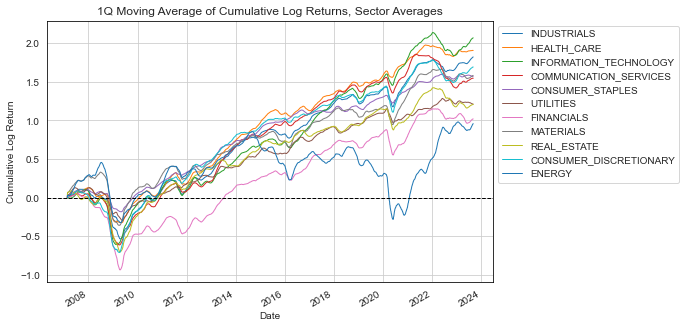

In [4]:
# Plot rolling n average of sector average cumulative return
n=63
sector_cum_ret_ma = targets.cumsum().rolling(n).mean()
sector_cum_ret_ma.loc[sector_cum_ret_ma.first_valid_index()] = 0
sector_cum_ret_ma.plot(figsize=(8, (8*(2/3))))
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title(f"{n//63}Q Moving Average of Cumulative Log Returns, Sector Averages")
plt.ylabel("Cumulative Log Return")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

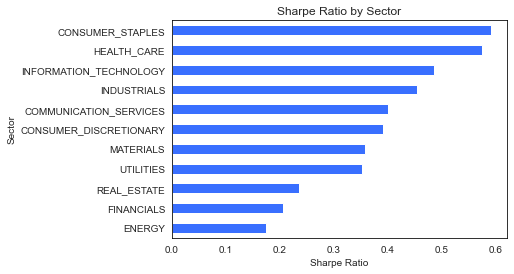

In [5]:
# Compute metrics for sector averages and plot Sharpe ratios
metrics = Metrics()
metric = "Sharpe Ratio"
sector_metrics = metrics.calculate(targets).sort_values(by=metric)

sector_metrics[metric].plot.barh(
    figsize=(6, (6*(2/3))),
    grid=False,
    color="#396FFF",
)

plt.title(f"{metric} by Sector")
plt.ylabel("Sector")
plt.xlabel("Sharpe Ratio")
plt.show()

In [6]:
# Create a PCA pipeline with StandardScaler and PCA components
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=.8, random_state=42))

# Fit the PCA model to the 'features' dataset and transform it
X_pca = pd.DataFrame(
    pca_pipe.fit_transform(features), 
    index=features.index
)

# Rename the columns of the transformed dataset as PC1, PC2, etc.
X_pca.columns = [f"PC{i+1}" for i in range(len(X_pca.columns))]

# Display the first 3 rows of the transformed dataset
X_pca.head(3)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-17,-0.432868,6.077293,0.037149,6.049114,1.439728,4.443866,-1.761093,-0.613848,2.116103,-1.220543,...,0.880474,-1.139674,1.048312,-0.459988,-0.173351,-1.252316,0.987566,-3.244779,-0.160941,0.262216
2006-11-20,0.732130,6.279048,-3.456766,5.017234,2.469282,5.474267,-2.199540,0.961626,1.628969,-1.496018,...,0.842074,0.338421,-0.331448,1.066916,-1.480853,-0.444610,-0.905920,-0.929168,-0.002427,0.054315
2006-11-21,0.595232,5.476677,-0.419648,5.440616,2.110901,6.139630,-2.770594,-0.498664,1.483933,-1.844016,...,0.637592,0.166990,0.785688,-0.569314,-1.061431,-0.275142,1.601485,-0.883149,0.513132,-0.368461


In [7]:
# Create a dictionary of regression models designed for working with stock returns
models = {
    # ElasticNet combines L1 and L2 regularization, suitable for feature selection and dealing with multicollinearity.
    'ElasticNet': make_pipeline(StandardScaler(), ElasticNet(random_state=42)),
    
    # Support Vector Regressor (SVR) with an RBF kernel can capture non-linear relationships in stock returns.
    'SVR': make_pipeline(StandardScaler(), SVR()),
    
    # RandomForestRegressor is an ensemble method that can capture complex relationships and feature importance.
    'RandomForest': RandomForestRegressor(random_state=42),
    
    # GradientBoostingRegressor is another ensemble method suitable for capturing non-linear relationships and trends.
    'GradientBoost': GradientBoostingRegressor(random_state=42),
    
    # XGBoostRegressor is an optimized gradient boosting algorithm known for its speed and performance.
    'XGBoost': XGBRegressor(random_state=42),
}

In [8]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint

oul_score = make_scorer(overunder_error, greater_is_better=False)

# Expanded parameter distributions for random search
param_distributions = {
    'ElasticNet': {
        'elasticnet__alpha': uniform(0.1, 1.9),
        'elasticnet__l1_ratio': uniform(0, 1)
    },
    'SVR': {
        'svr__C': uniform(0.1, 9.9),
        'svr__gamma': uniform(0.01, 0.99),
        'svr__epsilon': uniform(0.01, 0.1)
    },
    'RandomForest': {
        'n_estimators': randint(50, 201),
        'max_depth': randint(2, 11),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11)
    },
    'GradientBoost': {
        'n_estimators': randint(50, 201),
        'learning_rate': uniform(0.01, 0.29),
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 11)
    },
    'XGBoost': {
        'n_estimators': randint(50, 201),
        'learning_rate': uniform(0.01, 0.29),
        'max_depth': randint(2, 11),
        'min_child_weight': randint(1, 11),
        'gamma': uniform(0, 0.5),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5)
    }
}

In [9]:
# Set the forecast horizon to 126 days (approx. 1/2 trading year)
forecast = 126

# Initialize TimeSeriesSplit object for cross validation
cv = 2
tscv = TimeSeriesSplit(cv)

# Shift the features to match the forecast horizon and remove NA rows
X_pca_shifted = X_pca.shift(forecast).dropna()
# Reindex the target data to align with the shifted features
y_all = df[sectors].reindex(X_pca_shifted.index)

# Initialize empty DataFrames to store model predictions and Over-Under loss (OUL)
preds = {model: pd.DataFrame() for model in models.keys()}
ouls = {model: pd.DataFrame() for model in models.keys()}

# Loop through each sector in the target data
for sector in tqdm(y_all.columns):
    
    # Loop through each machine learning model
    for name, model in models.items():
        
        # Copy the shifted feature data
        X = X_pca_shifted.copy()
        # Copy the target data for the current sector
        y = y_all[sector]

        # Loop through the data in steps of 'forecast' days
        for i in range(forecast, len(y), forecast):
            
            # Split the data into rolling windows for training and testing
            X_train = VX = X.iloc[i-forecast:i]
            X_test = X.iloc[i:i+forecast]
            y_train = Vy = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]

            rand_search = RandomizedSearchCV(
                model, 
                param_distributions[name], 
                n_iter=50, 
                cv=tscv, 
                scoring=oul_score, 
                random_state=42,
                n_jobs=-1
            )

            rand_search.fit(X_train, y_train)
            new_model = rand_search.best_estimator_
            
            cv_ouls = []

            # Split the rolling training window into train and validation sets
            for idx_train, idx_test in tscv.split(VX):
                cvx_train, cvy_train = VX.iloc[idx_train], Vy.iloc[idx_train]
                cvx_test, cvy_test = VX.iloc[idx_test], Vy.iloc[idx_test]

                # Fit the model on the training set and validate on the validation set
                new_model.fit(cvx_train, cvy_train)
                cvy_hat = new_model.predict(cvx_test)

                # Append OUL to cross-val list
                cv_ouls.append(overunder_error(
                    cvy_test, cvy_hat, underpred_penalty=0, overpred_penalty=2
                ))
            
            # Take the mean of the OULs
            ouls[name].loc[X_test.index.min(), sector] = np.median(cv_ouls)
            
            # Fit the model on the full rolling training window and predict on the test set
            new_model.fit(X_train, y_train)
            y_hat = new_model.predict(X_test)
            
            # Store the mean of the predicted values, scaled to an annual basis
            preds[name].loc[X_test.index.min(), sector] = np.mean(y_hat) * 252

        # Convert the stored predictions and ouls to float type
        preds[name][sector] = preds[name][sector].astype(float)
        ouls[name][sector] = ouls[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [18:41<00:00, 101.93s/it]


In [10]:
# Determine the sector with the maximum value across time
model_preds = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds.items()}

# Concatenate the Series from each model into a single DataFrame
model_preds = pd.concat([pred for pred in model_preds.values()], axis=1)

# Display the first few rows of the model_preds DataFrame
model_preds.head()

,ElasticNet,SVR,RandomForest,GradientBoost,XGBoost
2007-11-20,ENERGY,INDUSTRIALS,ENERGY,ENERGY,ENERGY
2008-05-22,ENERGY,CONSUMER_STAPLES,ENERGY,COMMUNICATION_SERVICES,ENERGY
2008-11-19,CONSUMER_STAPLES,UTILITIES,REAL_ESTATE,REAL_ESTATE,CONSUMER_STAPLES
2009-05-22,CONSUMER_DISCRETIONARY,COMMUNICATION_SERVICES,CONSUMER_DISCRETIONARY,REAL_ESTATE,HEALTH_CARE
2009-11-19,REAL_ESTATE,REAL_ESTATE,CONSUMER_DISCRETIONARY,UTILITIES,REAL_ESTATE


In [11]:
# Calculate the mean of each DataFrame in the 'ouls' dictionary along the rows
mean_ouls = {model: pd.Series(oul.mean(axis=1), name=model) for model, oul in ouls.items()}

# Concatenate the mean Series from each model into a single DataFrame
mean_ouls = pd.concat([oul for oul in mean_ouls.values()], axis=1)

# Find the model with the minimum mean value for each row (axis=1)
best_models = mean_ouls.idxmin(axis=1)

# Display the first few rows of the best_models Series
best_models.head()

2007-11-20          XGBoost
2008-05-22          XGBoost
2008-11-19    GradientBoost
2009-05-22          XGBoost
2009-11-19    GradientBoost
dtype: object

In [12]:
# Create an empty DataFrame
results = pd.DataFrame(
    columns=["SELECTED_MODEL", "SELECTED_SECTOR", "AVAILABLE_STOCKS"],
    index=best_models.index
)

# Loop through dates in the best_models index
for date in best_models.index:

    # Get the best model for the current date
    best_model = best_models.loc[date]

    # Predict the selected sector using the best model
    selected_sector = model_preds.loc[date, best_model]

    # Store the selected model and sector in the results DataFrame
    results.loc[date, "SELECTED_MODEL"] = best_model
    results.loc[date, "SELECTED_SECTOR"] = selected_sector

    # Retrieve the selected sector's constituents from stocks_by_sector DataFrame
    sector_constituents = stocks_by_sector[stocks_by_sector["GICS Sector"] == selected_sector]["Symbol"]

    # Filter out constituents that are not in snp_log_returns columns
    sector_constituents = [c for c in sector_constituents if c in snp_log_returns.columns]

    # Store the available stocks as a space-separated string
    results.loc[date, "AVAILABLE_STOCKS"] = ' '.join(sector_constituents)

# Split the space-separated stock symbols into an array
results["AVAILABLE_STOCKS"] = results["AVAILABLE_STOCKS"].apply(lambda s: np.array(s.split()))

In [13]:
# Get unique available stocks from the results DataFrame
available_stocks = results.explode("AVAILABLE_STOCKS")['AVAILABLE_STOCKS'].unique()

# Create DataFrames to store allocations for different strategies
ms_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
mv_allocations = pd.DataFrame(columns=available_stocks, index=results.index)
rp_allocations = pd.DataFrame(columns=available_stocks, index=results.index)

# Initialize columns for Sharpe ratios in the results DataFrame
results[["EW_SHARPE", "MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = np.nan

# Loop through dates in the results index
for date in tqdm(results.index):

    # Get selected stocks for the current date
    selected_stocks = results.loc[date, "AVAILABLE_STOCKS"]

    # Retrieve past returns for selected stocks within the forecast window
    past_returns = snp_log_returns[selected_stocks].loc[:date][-forecast:]

    # Initialize equal-weighted portfolio weights
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

    # Calculate and store the Equal-Weighted (EW) Sharpe ratio
    results.at[date, "EW_SHARPE"] = opt.port_sharpe(weights, past_returns)

    # Calculate the Maximum Sharpe (MS) and Minimum Variance (MV) portfolios
    ms_w, ms_s = opt.max_sharpe_opt(weights, past_returns)
    mv_w, mv_s = opt.min_var_opt(weights, past_returns)

    # Calculate and store the Risk Parity (RP) portfolio
    rp_w, rp_s = opt.risk_parity_opt(weights, past_returns)

    # Store allocations for each strategy
    ms_allocations.loc[date, selected_stocks] = ms_w
    mv_allocations.loc[date, selected_stocks] = mv_w
    rp_allocations.loc[date, selected_stocks] = rp_w

    # Store Sharpe ratios for MS, MV, and RP strategies
    results.loc[date, ["MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = [ms_s, mv_s, rp_s]

# Drop the "AVAILABLE_STOCKS" column from the results DataFrame and display the first few rows
results.drop("AVAILABLE_STOCKS", axis=1).head()

100%|██████████| 32/32 [00:30<00:00,  1.03it/s]


,SELECTED_MODEL,SELECTED_SECTOR,EW_SHARPE,MS_SHARPE,MV_SHARPE,RP_SHARPE
2007-11-20,XGBoost,ENERGY,0.486888,1.778393,-0.130395,0.425154
2008-05-22,XGBoost,ENERGY,1.540243,2.894912,1.128711,1.444652
2008-11-19,GradientBoost,REAL_ESTATE,-2.243185,-0.907286,-1.767807,-2.268467
2009-05-22,XGBoost,HEALTH_CARE,0.768689,2.467070,0.006618,0.684807
2009-11-19,GradientBoost,UTILITIES,2.019092,3.340114,2.721390,2.104193


In [14]:
# Prune the allocation DataFrames (ms_allocations, mv_allocations, rp_allocations)
# by removing weights below a minimum weight threshold of 0.01 and re-normalizing the remaining weights.
ms_allocations, mv_allocations, rp_allocations = prune_allocations(
    ms_allocations, mv_allocations, rp_allocations, min_weight_th=0.01 
)

In [15]:
# Select constituent returns based on columns in ms_allocations
constituent_returns = snp_log_returns[ms_allocations.columns]

# Backtest portfolios for MS, MV, and RP strategies using the specified allocations
ms_port_rets, mv_port_rets, rp_port_rets = backtest_portfolios(
    ms_allocations, 
    mv_allocations, 
    rp_allocations, 
    constituent_returns=constituent_returns
)

# Calculate the equal-weighted portfolio returns by taking the mean of constituent returns
ew_port_rets = constituent_returns.sum(axis=1) / len(constituent_returns.columns)

# Reindex the equal-weighted portfolio returns to match the other portfolio returns' index
ew_port_rets = ew_port_rets.reindex(ms_port_rets.index)

# Set the return at the earliest date to 0 for consistency
ew_port_rets.loc[ew_port_rets.index.min()] = 0

In [18]:
# Concatenate the portfolio returns (ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets) horizontally
port_rets = pd.concat([ew_port_rets, ms_port_rets, mv_port_rets, rp_port_rets], axis=1)

# Rename the columns to describe each portfolio strategy
port_rets.columns = ["ONE_OVER_N", "MAX_SHARPE", "MIN_VAR", "RISK_PARITY"]

port_rets[sectors] = y_all.reindex(port_rets.index)

# Create an instance of the Metrics class
portfolio_metrics = Metrics()

# Calculate portfolio metrics (e.g., mean return, volatility, Sharpe ratio) using the Metrics class
portfolio_metrics.calculate(port_rets)

,Sharpe Ratio,Cumulative Return,Annualized Return,Annualized Volatility
INFORMATION_TECHNOLOGY,0.497557,2.030765,0.128646,0.258555
MAX_SHARPE,0.374204,1.966529,0.124577,0.332911
HEALTH_CARE,0.567896,1.768588,0.112037,0.197285
INDUSTRIALS,0.464587,1.754931,0.111172,0.239293
CONSUMER_DISCRETIONARY,0.415816,1.694966,0.107373,0.258224
COMMUNICATION_SERVICES,0.424361,1.542642,0.097724,0.230285
RISK_PARITY,0.329826,1.515631,0.096013,0.291101
ONE_OVER_N,0.416223,1.504212,0.095289,0.228938
CONSUMER_STAPLES,0.592437,1.451007,0.091919,0.155154
MIN_VAR,0.373656,1.403411,0.088904,0.237930


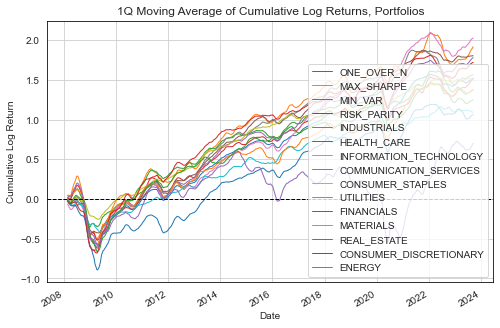

In [19]:
# Plot cumulative returns of each portfolio
port_rets.cumsum().rolling(n).mean().plot(figsize=(8, (8*(2/3))))
plt.axhline(0, linewidth=1, color="k", linestyle="--")
plt.title(f"{n//63}Q Moving Average of Cumulative Log Returns, Portfolios")
plt.ylabel("Cumulative Log Return")
plt.show()